## Load Packages

In [1]:
using Distributions

#using Dates            #Julia 0.7
using Compat, Missings  #to use 0.7 syntax in 0.6

include("printmat.jl")
include("printTable.jl")

printmatDate (generic function with 8 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

# Delta of an Option: A First-Order Approximation of a Change

"Delta hedging" is based on the idea that we can approximate the change in the option price by 

$C_{t+h}-C_{t}\approx\frac{\partial C_{t}}{\partial S}\left(  S_{t+h}-S_{t}\right)$


In the Black-Scholes model, the Delta of a call option is

$\Delta=\frac{\partial C}{\partial S}=e^{-\delta m}\Phi\left(  d_{1}\right),$ 

while the Delta of a put option is 

$\frac{\partial P}{\partial S}=e^{-\delta m}[\Phi\left(  d_{1}\right)-1]$.

In [3]:
function Φ(x)
    #Calculates Pr(z<=x) for N(0,1) variable z
    Pr = cdf(Normal(0,1),x)
    return Pr
end

function OptionDelta(S,K,m,y,σ,δ=0,PutIt=false)
    #Calculates Black-Scholes delta
    d1 = ( log(S/K) + (y-δ+0.5*σ^2)*m ) / (σ*sqrt(m))
    d2 = d1 - σ*sqrt(m)
    if PutIt 
        Δ = exp(-δ*m)*(Φ(d1)-1)
    else     
        Δ = exp(-δ*m)*Φ(d1)              
    end    
    return Δ
end

function OptionBlackSPs(S,K,m,y,σ,δ=0,PutIt=false)
    #Calculates Black-Scholes European call or put option price, continuous dividends of δ
    d1 = ( log(S/K) + (y-δ+0.5*σ^2)*m ) / (σ*sqrt(m))
    d2 = d1 - σ*sqrt(m)
    c  = exp(-δ*m)*S*Φ(d1) - K*exp(-y*m)*Φ(d2)
    if PutIt 
        price = c - exp(-δ*m)*S + exp(-y*m)*K    
    else     
        price = c
    end    
    return price      
end

OptionBlackSPs (generic function with 3 methods)

In [4]:
(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)

Δc = OptionDelta(S,K,m,y,σ)
Δp = OptionDelta(S,K,m,y,σ,0,true)
printlnPs("Δ of call and put and the difference: ",[Δc Δp (Δc-Δp)])

Δ of call and put and the difference:      0.598    -0.402     1.000


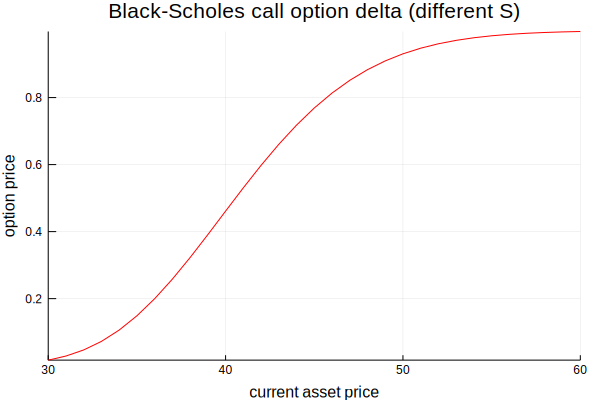

In [5]:
SM = 30:60
Δc_S = OptionDelta.(SM,K,m,y,σ)          #at different spot prices

plot(SM,Δc_S,color=:red,legend=false)
title!("Black-Scholes call option delta (different S)")
xlabel!("current asset price")
ylabel!("option price")

# Hedging an Option

The example below shows how a Delta hedging works for a European call option when the price of the underlying changes (from 42 on day 0 to 43 on day 1). For simplicity, we assume that the Black-Scholes model is a good description of how the option price is set.

In [6]:
(S₀,S₁,K,m,y,σ) = (42,43,42,0.5,0.05,0.2)

C₀ = OptionBlackSPs(S₀,K,m,y,σ)   #option price at S₀
Δ₀ = OptionDelta(S₀,K,m,y,σ)      #Delta at S₀
M₀ = C₀ - Δ₀*S₀                    #on money market account

C₁ = OptionBlackSPs(S₁,K,m-1/252,y,σ)   #option price at S₁ (it's one day later) 
dC = C₁ - C₀                      #change of option value         
dV = Δ₀*(S₁-S₀) - (C₁-C₀)           #change of hedge portfolio value

xy = [S₀,Δ₀,C₀,M₀,S₁,C₁,dC,dV]
printTable(xy,[" "],["S₀","Δ₀","C₀","M₀","S₁","C₁","dC","dV"])
println("V changes much less in values than the option: the hedge helps")

            
S₀    42.000
Δ₀     0.598
C₀     2.893
M₀   -22.212
S₁    43.000
C₁     3.509
dC     0.616
dV    -0.018

V changes much less in values than the option: the hedge helps
